# PokeClassifier

Gen1 Pokemon Image Classifier with Automatic Image Standardization

## Imports and Data Loading

In [13]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

### Model Hyperparameters

In [14]:
batch_size = 16
image_shape = (256,256,3)

In [15]:
train_path = 'TrainImages'
test_path = 'TestImages'


image_gen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 5830 images belonging to 149 classes.
Found 949 images belonging to 149 classes.


### Model Definition

In [16]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dropout(rate=0.1))

model.add(Dense(1024,activation='relu'))

model.add(Dropout(rate=0.1))

model.add(Dense(512,activation='relu'))

model.add(Dense(149,activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                      

### Training

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("my_model.h5", monitor="val_accuracy", save_best_only=True, period=3)
early_stopping = EarlyStopping(monitor='val_accuracy',patience=3)
results = model.fit(train_image_gen,epochs=80,validation_split=0.1,callbacks=[early_stopping, checkpoint])

Epoch 1/80
365/365 [==============================] - 141s 370ms/step - loss: 4.4637 - accuracy: 0.0587 - val_loss: 4.0152 - val_accuracy: 0.0896
Epoch 2/80
365/365 [==============================] - 129s 354ms/step - loss: 3.3838 - accuracy: 0.1684 - val_loss: 3.2995 - val_accuracy: 0.1823
Epoch 3/80
365/365 [==============================] - 129s 352ms/step - loss: 2.8748 - accuracy: 0.2523 - val_loss: 3.5532 - val_accuracy: 0.1781
Epoch 4/80
365/365 [==============================] - 128s 350ms/step - loss: 2.5385 - accuracy: 0.3254 - val_loss: 2.5915 - val_accuracy: 0.3446
Epoch 5/80
365/365 [==============================] - 128s 350ms/step - loss: 2.2543 - accuracy: 0.3952 - val_loss: 2.3166 - val_accuracy: 0.4162
Epoch 6/80
365/365 [==============================] - 126s 346ms/step - loss: 2.0882 - accuracy: 0.4400 - val_loss: 3.1398 - val_accuracy: 0.2972
Epoch 7/80
365/365 [==============================] - 129s 352ms/step - loss: 1.8767 - accuracy: 0.4842 - val_loss: 2.1785 -

### Evalute Model

60/60 [==============================] - 17s 286ms/step - loss: 2.1454 - accuracy: 0.5279


<AxesSubplot: >

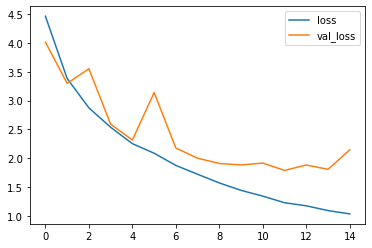

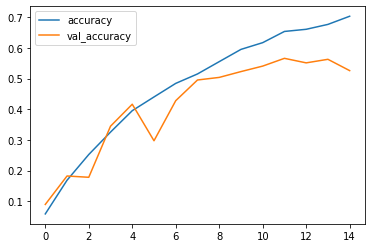

In [19]:
loss_history = pd.DataFrame(model.history.history)

model.evaluate(test_image_gen)
loss_history[['loss','val_loss']].plot()
loss_history[['accuracy','val_accuracy']].plot()